# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


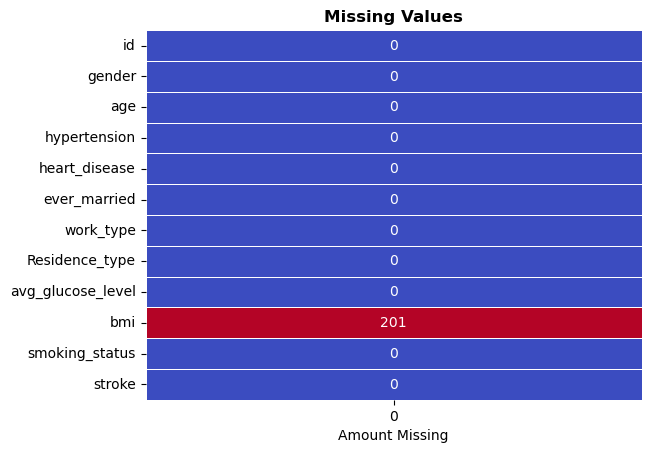

In [4]:
plt.title('Missing Values',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5,cbar=False)
ax.set_xlabel('Amount Missing')
plt.show()

### Fill missing values

In [5]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

Text(0.5, 1.0, 'Stroke')

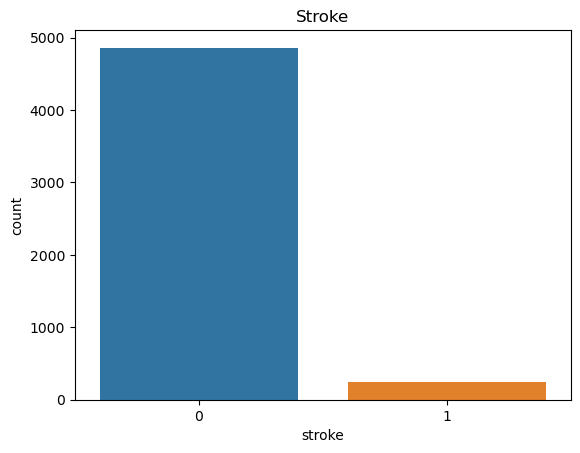

In [6]:
sns.countplot(data=df, x="stroke")
plt.title('Stroke')

# Model preparation

In [7]:
from sklearn.preprocessing import LabelEncoder

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1})
df['ever_married'] = df['ever_married'].replace({'No':0,'Yes':1})
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})
df['work_type'] = df['work_type'].replace({'Never_worked':-2,
                                           'children':-1, 
                                           'Private':0,
                                           'Self-employed':1,
                                           'Govt_job':2})

df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])

## Split dataset

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

## Balance dataset

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
oversampler = SMOTE(sampling_strategy = 1)

X, y = oversampler.fit_resample(X,y)

X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<Axes: xlabel='stroke', ylabel='count'>

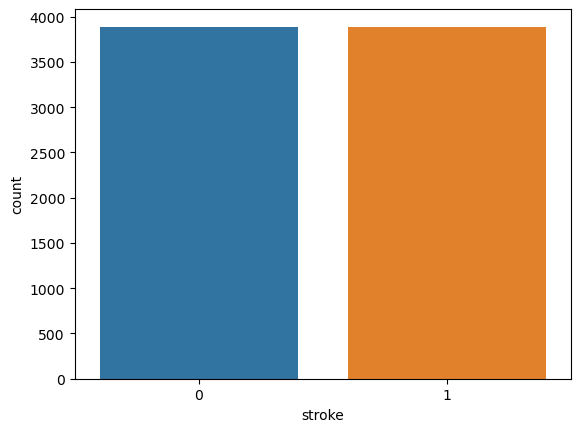

In [11]:
sns.countplot(x=y_train_res)

## Building Models

### RandomForest

In [12]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix



rf_pipeline = Pipeline(steps = [
                                ('KNN',KNeighborsClassifier())])


# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# rf_cv = cross_val_score(rf_pipeline,
#                         X_train_res,
#                         y_train_res,
#                         cv=cv,
#                         scoring='f1')

In [13]:
rf_pipeline.fit(X_train_res, y_train_res)
y_pred = rf_pipeline.predict(X_test)

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       973
           1       0.85      0.99      0.91       972

    accuracy                           0.90      1945
   macro avg       0.91      0.90      0.90      1945
weighted avg       0.91      0.90      0.90      1945



In [15]:
rf_pipeline.score(X_test, y_test)

0.9033419023136247

<Axes: >

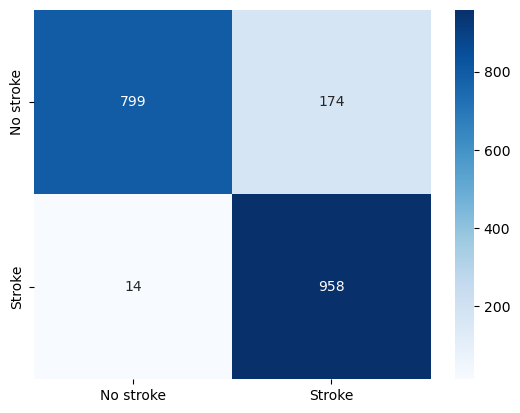

In [16]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['No stroke', 'Stroke'], yticklabels=['No stroke', 'Stroke'])

# Building neural network

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.fit_transform(X_test)

In [19]:
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

from sklearn.metrics import f1_score
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
def select_model(layers, activation):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=X_train_res.shape[1], activation=activation))
    for i, node in enumerate(layers[1:]):
        model.add(Dense(node, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [21]:
model = KerasClassifier(select_model, verbose=1)

In [22]:
# layers = [[10], [30, 15], [30, 15, 5], [45, 30, 15, 5]]
# activations = ['tanh','relu']

# grid = GridSearchCV(estimator = model, param_grid = dict(layers = layers,
#                                                      activation = activations, 
#                                                     batch_size = [64],
#                                                     epochs=[30]))

# grid_res = grid.fit(X_train_res, y_train_res)

In [23]:
# [grid_res.best_score_, grid_res.best_params_]

In [24]:
model = select_model([45, 30, 15, 5], 'tanh')

In [41]:
# model.fit(X_train_res, y_train_res, batch_size=64, epochs=300, validation_data=(X_test, y_test), verbose=2)

Epoch 1/300
122/122 - 1s - loss: 0.1149 - accuracy: 0.9578 - val_loss: 1.3750 - val_accuracy: 0.7707 - 1s/epoch - 9ms/step
Epoch 2/300
122/122 - 0s - loss: 0.1081 - accuracy: 0.9598 - val_loss: 1.3322 - val_accuracy: 0.7758 - 247ms/epoch - 2ms/step
Epoch 3/300
122/122 - 0s - loss: 0.1089 - accuracy: 0.9603 - val_loss: 1.3723 - val_accuracy: 0.7743 - 258ms/epoch - 2ms/step
Epoch 4/300
122/122 - 0s - loss: 0.1043 - accuracy: 0.9627 - val_loss: 1.4119 - val_accuracy: 0.7661 - 277ms/epoch - 2ms/step
Epoch 5/300
122/122 - 0s - loss: 0.1037 - accuracy: 0.9613 - val_loss: 1.4156 - val_accuracy: 0.7712 - 277ms/epoch - 2ms/step
Epoch 6/300
122/122 - 0s - loss: 0.1022 - accuracy: 0.9630 - val_loss: 1.3935 - val_accuracy: 0.7769 - 249ms/epoch - 2ms/step
Epoch 7/300
122/122 - 0s - loss: 0.1046 - accuracy: 0.9607 - val_loss: 1.4534 - val_accuracy: 0.7650 - 251ms/epoch - 2ms/step
Epoch 8/300
122/122 - 0s - loss: 0.1053 - accuracy: 0.9601 - val_loss: 1.4202 - val_accuracy: 0.7614 - 244ms/epoch - 2ms/

Epoch 66/300
122/122 - 0s - loss: 0.1014 - accuracy: 0.9623 - val_loss: 1.5054 - val_accuracy: 0.7661 - 252ms/epoch - 2ms/step
Epoch 67/300
122/122 - 0s - loss: 0.1093 - accuracy: 0.9594 - val_loss: 1.5078 - val_accuracy: 0.7584 - 261ms/epoch - 2ms/step
Epoch 68/300
122/122 - 0s - loss: 0.1024 - accuracy: 0.9625 - val_loss: 1.5100 - val_accuracy: 0.7630 - 265ms/epoch - 2ms/step
Epoch 69/300
122/122 - 0s - loss: 0.0987 - accuracy: 0.9623 - val_loss: 1.4924 - val_accuracy: 0.7650 - 248ms/epoch - 2ms/step
Epoch 70/300
122/122 - 0s - loss: 0.1003 - accuracy: 0.9632 - val_loss: 1.5249 - val_accuracy: 0.7573 - 250ms/epoch - 2ms/step
Epoch 71/300
122/122 - 0s - loss: 0.1009 - accuracy: 0.9618 - val_loss: 1.5073 - val_accuracy: 0.7568 - 250ms/epoch - 2ms/step
Epoch 72/300
122/122 - 0s - loss: 0.1040 - accuracy: 0.9601 - val_loss: 1.4811 - val_accuracy: 0.7645 - 254ms/epoch - 2ms/step
Epoch 73/300
122/122 - 0s - loss: 0.1071 - accuracy: 0.9587 - val_loss: 1.5646 - val_accuracy: 0.7640 - 250ms/e

Epoch 131/300
122/122 - 0s - loss: 0.0973 - accuracy: 0.9644 - val_loss: 1.5601 - val_accuracy: 0.7614 - 251ms/epoch - 2ms/step
Epoch 132/300
122/122 - 0s - loss: 0.0985 - accuracy: 0.9641 - val_loss: 1.5771 - val_accuracy: 0.7625 - 250ms/epoch - 2ms/step
Epoch 133/300
122/122 - 0s - loss: 0.0941 - accuracy: 0.9657 - val_loss: 1.6082 - val_accuracy: 0.7563 - 251ms/epoch - 2ms/step
Epoch 134/300
122/122 - 0s - loss: 0.0981 - accuracy: 0.9635 - val_loss: 1.5823 - val_accuracy: 0.7630 - 249ms/epoch - 2ms/step
Epoch 135/300
122/122 - 0s - loss: 0.0934 - accuracy: 0.9659 - val_loss: 1.5957 - val_accuracy: 0.7548 - 249ms/epoch - 2ms/step
Epoch 136/300
122/122 - 0s - loss: 0.0919 - accuracy: 0.9661 - val_loss: 1.5854 - val_accuracy: 0.7599 - 253ms/epoch - 2ms/step
Epoch 137/300
122/122 - 0s - loss: 0.0973 - accuracy: 0.9652 - val_loss: 1.5915 - val_accuracy: 0.7568 - 251ms/epoch - 2ms/step
Epoch 138/300
122/122 - 0s - loss: 0.0963 - accuracy: 0.9641 - val_loss: 1.5798 - val_accuracy: 0.7584 -

122/122 - 0s - loss: 0.0894 - accuracy: 0.9670 - val_loss: 1.7047 - val_accuracy: 0.7563 - 249ms/epoch - 2ms/step
Epoch 196/300
122/122 - 0s - loss: 0.0934 - accuracy: 0.9640 - val_loss: 1.6832 - val_accuracy: 0.7599 - 252ms/epoch - 2ms/step
Epoch 197/300
122/122 - 0s - loss: 0.0936 - accuracy: 0.9662 - val_loss: 1.6887 - val_accuracy: 0.7506 - 251ms/epoch - 2ms/step
Epoch 198/300
122/122 - 0s - loss: 0.0959 - accuracy: 0.9640 - val_loss: 1.7085 - val_accuracy: 0.7578 - 252ms/epoch - 2ms/step
Epoch 199/300
122/122 - 0s - loss: 0.0913 - accuracy: 0.9668 - val_loss: 1.6662 - val_accuracy: 0.7604 - 249ms/epoch - 2ms/step
Epoch 200/300
122/122 - 0s - loss: 0.0924 - accuracy: 0.9664 - val_loss: 1.7365 - val_accuracy: 0.7558 - 254ms/epoch - 2ms/step
Epoch 201/300
122/122 - 0s - loss: 0.0947 - accuracy: 0.9661 - val_loss: 1.7016 - val_accuracy: 0.7537 - 253ms/epoch - 2ms/step
Epoch 202/300
122/122 - 0s - loss: 0.0953 - accuracy: 0.9646 - val_loss: 1.6483 - val_accuracy: 0.7532 - 252ms/epoch -

Epoch 260/300
122/122 - 0s - loss: 0.0859 - accuracy: 0.9693 - val_loss: 1.7616 - val_accuracy: 0.7548 - 251ms/epoch - 2ms/step
Epoch 261/300
122/122 - 0s - loss: 0.0878 - accuracy: 0.9695 - val_loss: 1.7124 - val_accuracy: 0.7625 - 252ms/epoch - 2ms/step
Epoch 262/300
122/122 - 0s - loss: 0.0879 - accuracy: 0.9666 - val_loss: 1.6822 - val_accuracy: 0.7553 - 251ms/epoch - 2ms/step
Epoch 263/300
122/122 - 0s - loss: 0.0901 - accuracy: 0.9671 - val_loss: 1.7500 - val_accuracy: 0.7604 - 250ms/epoch - 2ms/step
Epoch 264/300
122/122 - 0s - loss: 0.0879 - accuracy: 0.9676 - val_loss: 1.6936 - val_accuracy: 0.7620 - 250ms/epoch - 2ms/step
Epoch 265/300
122/122 - 0s - loss: 0.0883 - accuracy: 0.9675 - val_loss: 1.7300 - val_accuracy: 0.7609 - 251ms/epoch - 2ms/step
Epoch 266/300
122/122 - 0s - loss: 0.0886 - accuracy: 0.9689 - val_loss: 1.7216 - val_accuracy: 0.7609 - 262ms/epoch - 2ms/step
Epoch 267/300
122/122 - 0s - loss: 0.0971 - accuracy: 0.9643 - val_loss: 1.7988 - val_accuracy: 0.7594 -

In [42]:
# model.save('test_model.md5')

INFO:tensorflow:Assets written to: test_model.md5\assets


In [43]:
model = load_model('test_model.md5')

61/61 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       973
           1       0.83      0.68      0.75       972

    accuracy                           0.77      1945
   macro avg       0.78      0.77      0.77      1945
weighted avg       0.78      0.77      0.77      1945



<Axes: >

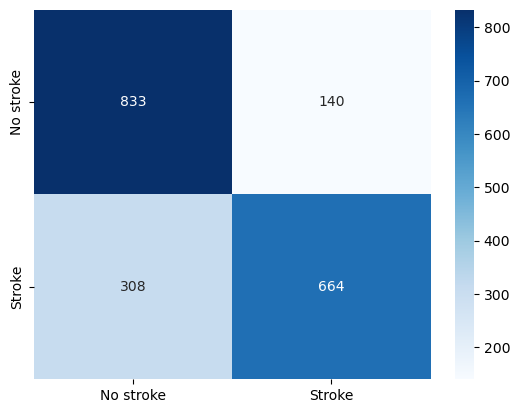

In [40]:
y_pred = model.predict(X_test)

y_pred = y_pred > 0.5

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['No stroke', 'Stroke'], yticklabels=['No stroke', 'Stroke'])

## Classifiers

1. KNN
2. SVM
3. DecissionTree
4. XGB
5. CatBoost
6. AdaBoost
